# Data Importing, Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                  names = ['fix_acid', 'vol_acid', 'cit_acid', 'resid_sugar', 'chlorides', 'free_sulfur_dioxide','total_sulfur_dioxide',
                           'density','pH','sulphates','alcohol','quality'])

In [3]:
data = data['fix_acid'].str.split(';', expand = True).drop(index = 0)

data = data.rename(columns={0:'fix_acid', 1:'vol_acid', 2:'cit_acid',3:'resid_sugar',4:'chlorides', 5:'free_sulfur_dioxide',
                     6:'total_sulfur_dioxide',7:'density',8:'pH',9:'sulphates',10:'alcohol', 11:'quality'})

data[['fix_acid', 'vol_acid', 'cit_acid', 'resid_sugar', 'chlorides', 'free_sulfur_dioxide','total_sulfur_dioxide',
                           'density','pH','sulphates','alcohol']] = data[['fix_acid', 'vol_acid', 'cit_acid', 'resid_sugar', 'chlorides', 'free_sulfur_dioxide','total_sulfur_dioxide',
                           'density','pH','sulphates','alcohol']].astype('float')

data['quality'] = data['quality'].astype(float)

In [4]:
data.shape

(1599, 12)

In [5]:
data.describe()

,fix_acid,vol_acid,cit_acid,resid_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
describe_data=data.describe()
writer = pd.ExcelWriter('describe.xlsx', engine = 'xlsxwriter')
describe_data.to_excel(writer, sheet_name='Table', index=False)
writer.save()

##### Dropping Outliers

In [7]:
data = data.drop(data[data['free_sulfur_dioxide'] > (21-7)*1.5+21].index)
data = data.drop(data[data['total_sulfur_dioxide'] > (62-22)*1.5+62].index)
data = data.drop(data[data['resid_sugar'] > (2.6-1.9)*1.5+2.6].index)

data = data.drop(data[data['resid_sugar'] > (2.6-1.9)*1.5+2.6].index)

#### Correlogram

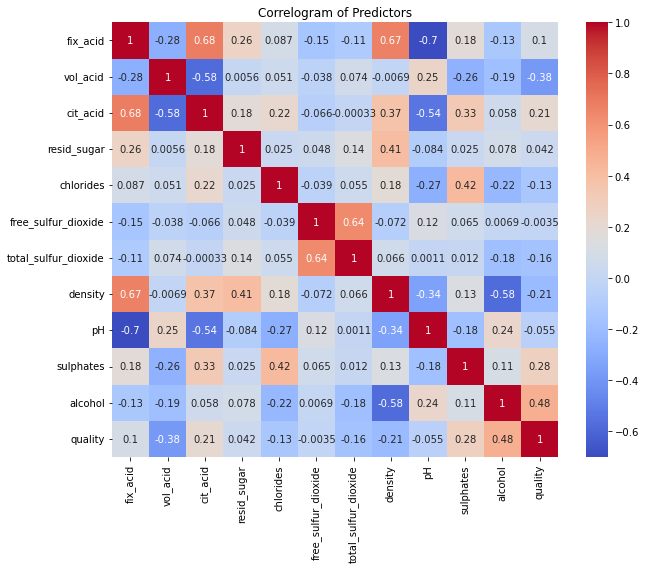

In [8]:
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, ax=ax)
ax.set_title("Correlogram of Predictors")


plt.savefig('correlogram.png',  bbox_inches='tight')
plt.show()

##### Dealing with multicollinarity

In [9]:
data = data.drop('pH', axis=1)

In [10]:
data.shape

(1390, 11)

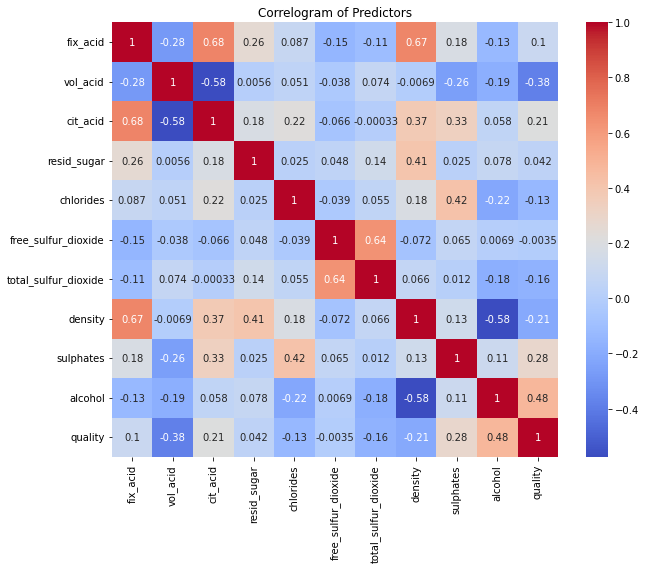

In [11]:
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, ax=ax)
ax.set_title("Correlogram of Predictors")


plt.savefig('correlogram1.png',  bbox_inches='tight')
plt.show()

# 

## Splitting Data 1: Seperating predictors and dependent variable

In [12]:
X1 = data
X1 = X1.drop('quality', axis=1)

y1 = data['quality']

# 

## Model Selection 1: Optimal n. of predictors

In [13]:
from sklearn.linear_model import LassoCV

###  Lasso CV - Setting optimal number of predictors

In [14]:
lasso_cv = LassoCV(cv=5)

lasso_cv.fit(X1, y1)

print('Optimal number of predictors:', np.count_nonzero(lasso_cv.coef_))
print('Optimal alpha value:', lasso_cv.alpha_)
print('Selected features:', X1.columns[np.abs(lasso_cv.coef_) > 0])

Optimal number of predictors: 7
Optimal alpha value: 0.00343554267377465
Selected features: Index(['fix_acid', 'vol_acid', 'cit_acid', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'sulphates', 'alcohol'],
      dtype='object')


# 

## Splitting Data 2: Optimal predictors. Train, Test and Holdout sets

In [13]:
from sklearn.model_selection import train_test_split

X = data[['fix_acid', 'vol_acid', 'cit_acid', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'sulphates', 'alcohol']]

y = data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size=0.5, random_state=90)

## Model Selection 2: Cross-validation

In [14]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score

In [15]:
# For some regressors few parameters were added to increase their performance. Later, there will be optimization of parameters of the 2 best model.
models = [LinearRegression(), Lasso(alpha=0.0034355), DecisionTreeRegressor(max_features=4,min_samples_split=5, min_samples_leaf=2),
          RandomForestRegressor(), GradientBoostingRegressor(), SVR(kernel='linear',C=2.0,tol=0.01, degree=5,cache_size=500), XGBRegressor(n_estimators=250)]

rmse_scores = []
r2_scores = []
mae_scores = []

#### Getting evaluation metrics using cross-validation

In [16]:
%%time
for model in models:
    rmse_scores.append(np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")).mean())
    mae_scores.append(-cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean())
    r2_scores.append(cross_val_score(model, X_train, y_train, cv=5).mean())

CPU times: total: 34 s
Wall time: 26.5 s


# 

# Graphing the evaluation metrics

### RMSE Scores

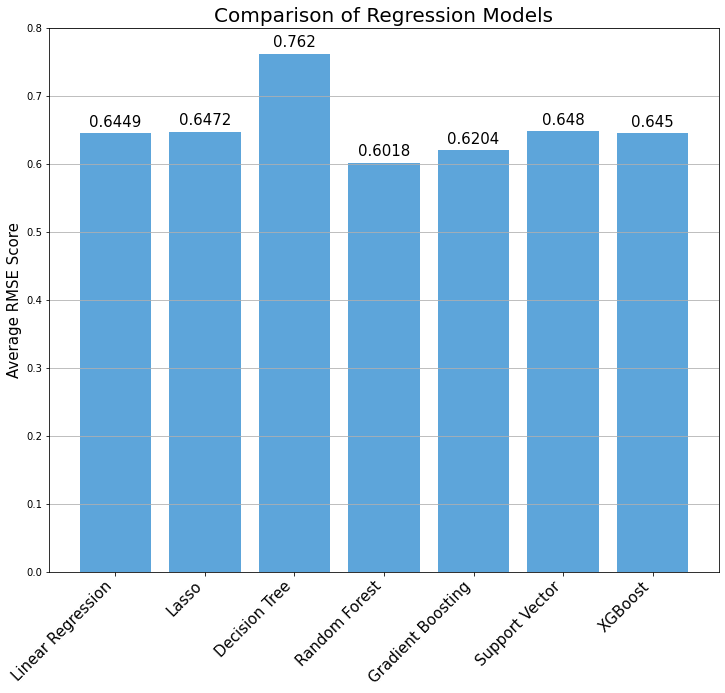

In [17]:
fig, ax = plt.subplots(figsize=(12,10))

ax.bar(range(len(models)),rmse_scores, color='#5DA5DA')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(['Linear Regression','Lasso','Decision Tree','Random Forest','Gradient Boosting','Support Vector', 'XGBoost'], rotation = 45, ha='right', fontsize=15)
ax.set_ylabel('Average RMSE Score', fontsize=15)
ax.set_title('Comparison of Regression Models', fontsize=20)
ax.grid(axis='y')

for i, v in enumerate(rmse_scores):
    ax.text(i, v + 0.01, str(round(v,4)), ha='center', fontsize=15)
    
plt.savefig('regmodrmse.png',  bbox_inches='tight')
plt.show()

### MAE Scores

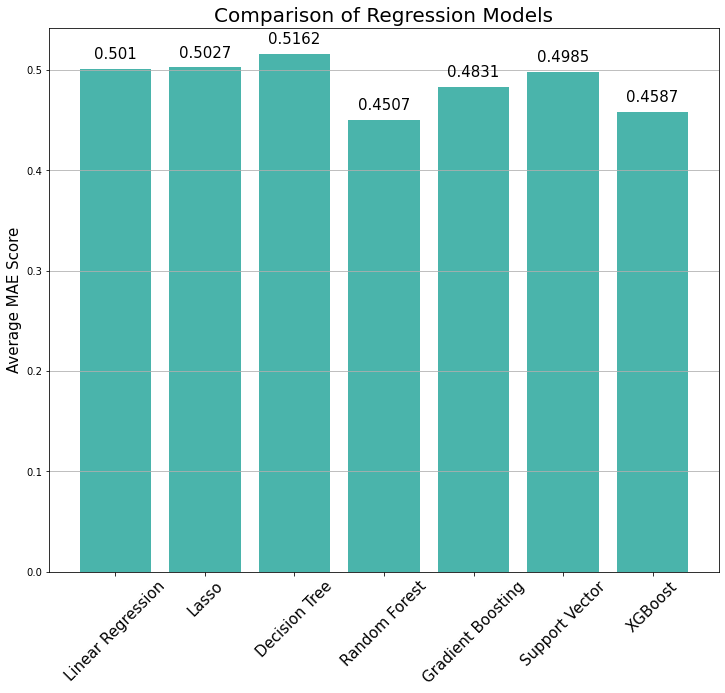

In [18]:
fig, ax = plt.subplots(figsize=(12,10))

ax.bar(range(len(models)),mae_scores, color='#4AB4AB')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(['Linear Regression','Lasso','Decision Tree','Random Forest','Gradient Boosting','Support Vector', 'XGBoost'], rotation = 45, ha='center', fontsize=15)
ax.set_ylabel('Average MAE Score', fontsize=15)
ax.set_title('Comparison of Regression Models', fontsize=20)
ax.grid(axis='y')

for i, v in enumerate(mae_scores):
    ax.text(i, v + 0.01, str(round(v,4)), ha='center', fontsize=15)
    
plt.savefig('regmodmae.png',  bbox_inches='tight')
plt.show()

### R2 Scores

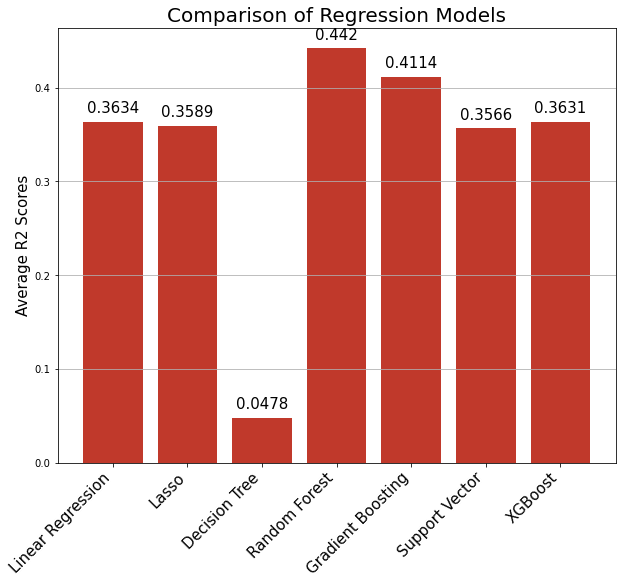

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(range(len(models)), r2_scores, color='#C0392B')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(['Linear Regression','Lasso','Decision Tree','Random Forest','Gradient Boosting','Support Vector', 'XGBoost'], rotation = 45, ha='right',fontsize=15)
ax.set_ylabel('Average R2 Scores', fontsize=15)
ax.set_title('Comparison of Regression Models', fontsize=20)
ax.grid(axis='y')

for i, v in enumerate(r2_scores):
    ax.text(i, v+0.01, str(round(v,4)),fontsize=15, ha='center')
    
plt.savefig('regmodr2.png',  bbox_inches='tight')

### Selecting two best models

In [20]:
df = pd.DataFrame({"RMSE": rmse_scores,"MAE":mae_scores,"R2":r2_scores})

names_model=pd.Series(['Linear','Lasso','Decision Tree','Random Forest','Gradient Boosting','Support Vector', 'XGBoost'], name = 'Model')
names_model

df = df.join(names_model)
df = pd.concat([df.iloc[:, -1:], df.iloc[:, :-1]], axis=1)
df.sort_values('RMSE')

,Model,RMSE,MAE,R2
3,Random Forest,0.601812,0.450669,0.442041
4,Gradient Boosting,0.620362,0.483114,0.411424
0,Linear,0.644887,0.500983,0.363418
6,XGBoost,0.644982,0.458706,0.363113
1,Lasso,0.647225,0.502702,0.358886
5,Support Vector,0.648002,0.498506,0.356599
2,Decision Tree,0.761985,0.516172,0.047812


#### Models 3 (RF) and 4 (GB) are outperforming other models.

# 

# Optimize Tuning Parameters of RF and GB

In [37]:
from sklearn.model_selection import GridSearchCV

#### Defining Model Parameters

In [38]:
%%time

# Random Forest Parameters
rf_param = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 250, 275, 300, 350],
    'max_depth': [1, 5, 10, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Gradient Boosting Parameters
gb_param = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 250, 275, 300, 350],
    'max_depth': [1, 3, 5, 10, None],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.25, 0.1, 0.05, 0.01],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

# Searching for best parameters using GridSearchCV

rf_grid = GridSearchCV(rf, rf_param, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)

gb_grid = GridSearchCV(gb, gb_param, cv=5, n_jobs=-1)
gb_grid.fit(X_train, y_train)

print('Random Forest - Best Parameters: ', rf_grid.best_params_)
print('Gradient Boosting - Best Parameters: ', gb_grid.best_params_)

Random Forest - Best Parameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Gradient Boosting - Best Parameters:  {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350}
CPU times: total: 1min 54s
Wall time: 40min 42s


#### Using optimal parameters and visualizing model performance

In [107]:
RF = RandomForestRegressor(max_depth = None , max_features = 'log2', min_samples_leaf = 1,
                           min_samples_split = 2, n_estimators = 150)

GB = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 10, max_features = 'log2',
                               min_samples_leaf = 1, min_samples_split = 2, n_estimators = 350)

best_models = [RF, GB]

In [148]:
RF.fit(X_train, y_train)
GB.fit(X_train, y_train)

rf_predict = RF.predict(X_test)
gb_predict = GB.predict(X_test)

##### RFM Scatter

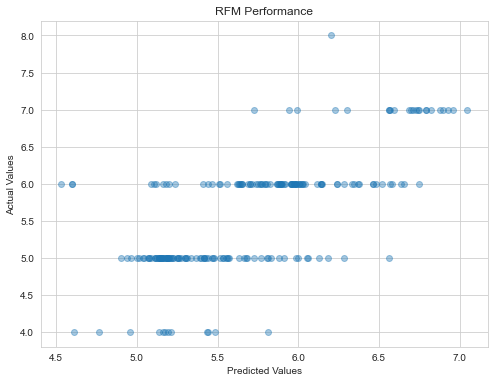

In [149]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.scatter(rf_predict, y_test, alpha=0.4)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('RFM Performance')

plt.savefig('rfm_performance.png')
plt.show()

##### GBM Scatter

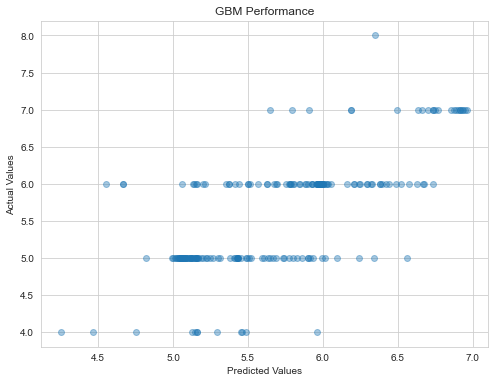

In [150]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(gb_predict, y_test, alpha = 0.4)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('GBM Performance')

plt.savefig('gbm_performance.png')
plt.show()

In [45]:
%%time
best_rmse_scores = []
best_mae_scores = []
best_r2_scores = []

for model in best_models:
    best_rmse_scores.append(np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_squared_error")).mean())
    best_mae_scores.append(-cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_absolute_error").mean())
    best_r2_scores.append(cross_val_score(model, X_train, y_train, cv=5).mean())

CPU times: total: 10.5 s
Wall time: 13 s


## Visualizing the evaluation metrics

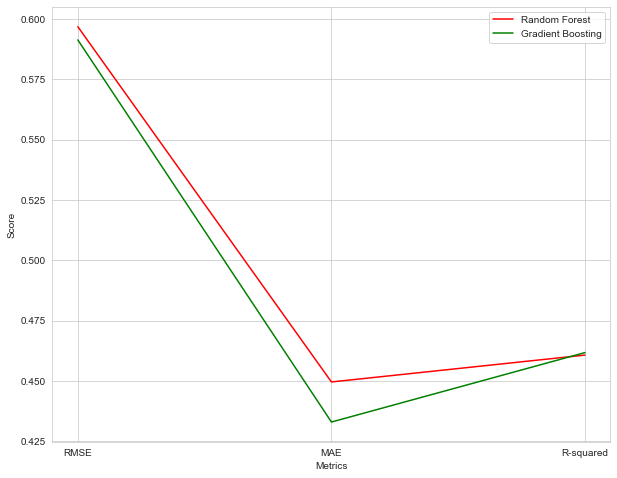

In [159]:
fig, ax = plt.subplots(figsize=(10,8))

labels = ['Random Forest', 'Gradient Boosting']
colors = ['r', 'g']

for i in range(len(best_models)):
    ax.plot([best_rmse_scores[i], best_mae_scores[i], best_r2_scores[i]], color=colors[i], label=labels[i])

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['RMSE', 'MAE', 'R-squared'])
ax.legend()

plt.savefig('bestmodelperformance.png', bbox_inches='tight')
plt.show()

# 

# Evaluating model performance on the holdout set

In [186]:
RF.fit(X_train, y_train)
GB.fit(X_train, y_train)

y_pred_RF_holdout = RF.predict(X_holdout)
y_pred_GB_holdout = GB.predict(X_holdout)

In [178]:
# RFM
rmse_RF_holdout = mean_squared_error(y_holdout, y_pred_RF_holdout, squared=False)
mae_RF_holdout = mean_absolute_error(y_holdout, y_pred_RF_holdout)
r2_RF_holdout = r2_score(y_holdout, y_pred_RF_holdout)

# GBM
rmse_GB_holdout = mean_squared_error(y_holdout, y_pred_GB_holdout, squared=False)
mae_GB_holdout = mean_absolute_error(y_holdout, y_pred_GB_holdout)
r2_GB_holdout = r2_score(y_holdout, y_pred_GB_holdout)

print(f"RF Model Performance: RMSE = {round(rmse_RF_holdout,4)}, MAE = {round(mae_RF_holdout,4)}, R2 = {round(r2_RF_holdout,4)}")
print(f"GB Model Performance: RMSE = {round(rmse_GB_holdout,4)}, MAE = {round(mae_GB_holdout,4)}, R2 = {round(r2_GB_holdout,4)}")

RF Model Performance: RMSE = 0.558, MAE = 0.4096, R2 = 0.4324
GB Model Performance: RMSE = 0.5659, MAE = 0.3927, R2 = 0.4162


##### RFM Scatter - Performance on Holdout Set

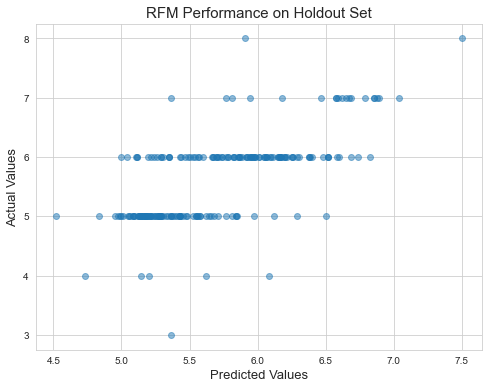

In [193]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(y_pred_RF_holdout, y_holdout, alpha=0.5)
plt.xlabel('Predicted Values', fontsize=13)
plt.ylabel('Actual Values', fontsize=13)
plt.title('RFM Performance on Holdout Set', fontsize=15)

plt.savefig('scatter_rf_holdout.png', bbox_inches='tight')
plt.show()

##### GBM Performance on Holdout Set

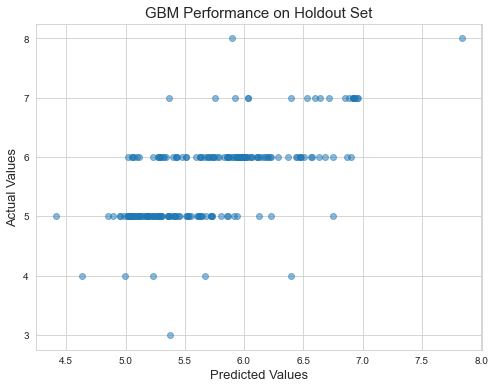

In [194]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(y_pred_GB_holdout, y_holdout, alpha=0.5)
plt.xlabel('Predicted Values', fontsize=13)
plt.ylabel('Actual Values', fontsize=13)
plt.title('GBM Performance on Holdout Set', fontsize=15)

plt.savefig('scatter_gb_holdout.png', bbox_inches='tight')
plt.show()

In [195]:
data_dict = {'Model': ['Random F', 'Random F', 'Random F', 'Gradient B', 'Gradient B', 'Gradient B'],
             'Metric': ['RMSE', 'MAE', 'R2', 'RMSE', 'MAE', 'R2'],
             'Value': [rmse_RF_holdout, mae_RF_holdout, r2_RF_holdout,
                       rmse_GB_holdout, mae_GB_holdout, r2_GB_holdout]}

df1 = pd.DataFrame(data_dict)

##### Visualizing Evaluation Metrics

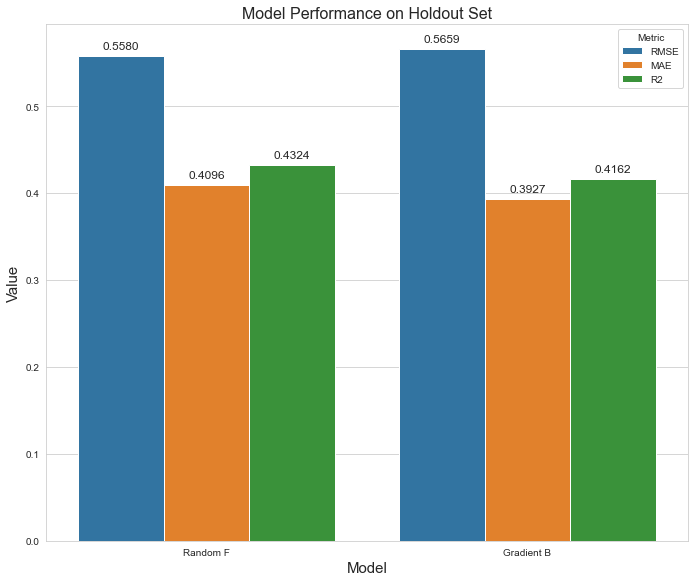

In [197]:
plt.figure(figsize=(11.5,9.5))

sns.set_style('whitegrid')

ax = sns.barplot(data=df1, x='Model', y='Value', hue='Metric')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points', fontsize=12)

ax.set_title('Model Performance on Holdout Set',fontsize=16)
ax.set_ylabel('Value', fontsize = 15)
ax.set_xlabel('Model', fontsize = 15)

plt.savefig('modelperformanceholdout.png', bbox_inches='tight')
plt.show()